In [113]:
# Import series of helper functions for our notebook
from helper_script import create_tensorboard_callback, plot_loss_curves, compare_history, walk_through_dir, save_model, load_model

In [114]:
walk_through_dir("images")

There are 2 directories and 0 images in 'images'.
There are 4 directories and 0 images in 'images\test'.
There are 0 directories and 282 images in 'images\test\Alto 2015'.
There are 0 directories and 101 images in 'images\test\Hero Dash 2016'.
There are 0 directories and 187 images in 'images\test\Toyota Aqua 2014'.
There are 0 directories and 165 images in 'images\test\Wagon R Stingray 2018'.
There are 4 directories and 0 images in 'images\train'.
There are 0 directories and 1115 images in 'images\train\Alto 2015'.
There are 0 directories and 411 images in 'images\train\Hero Dash 2016'.
There are 0 directories and 749 images in 'images\train\Toyota Aqua 2014'.
There are 0 directories and 659 images in 'images\train\Wagon R Stingray 2018'.


In [115]:
train_dir = "images/train"
test_dir = "images/test"

import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = "categorical",
                                                                batch_size = BATCH_SIZE,
                                                                shuffle=False,
                                                                crop_to_aspect_ratio=True)

Found 2934 files belonging to 4 classes.
Found 735 files belonging to 4 classes.


## Loading the saved feature extraction model

In [116]:
loaded_model_1 = load_model("feature_extraction_model_1")

In [117]:
loaded_model_1.evaluate(test_data)

23/23 [==============================] - 9s 332ms/step - loss: 0.1370 - accuracy: 0.9633


[0.13697946071624756, 0.9632652997970581]

## Making Predictions using the loaded model

In [118]:
# Make predictions with model
pred_probs = loaded_model_1.predict(test_data, verbose=1) # set verbosity to see how long is left

23/23 [==============================] - 9s 330ms/step


In [119]:
# Checking the shape of the predictions
pred_probs.shape

(735, 4)

In [120]:
# Checking the first prediction
pred_probs[0]

array([9.9383521e-01, 3.0184747e-05, 5.9397407e-03, 1.9491294e-04],
      dtype=float32)

In [121]:
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 4
What prediction probability sample 0 looks like:
 [9.9383521e-01 3.0184747e-05 5.9397407e-03 1.9491294e-04]
The class with the highest predicted probability by the model for sample 0: 0


In [122]:
# Get the pred classes of each label
pred_classes = pred_probs.argmax(axis=1)

pred_classes[:4]

array([0, 0, 0, 0], dtype=int64)

In [123]:
len(pred_classes)

735

In [124]:
# Get a list of class names
class_names = test_data.class_names
class_names

['Alto 2015', 'Hero Dash 2016', 'Toyota Aqua 2014', 'Wagon R Stingray 2018']

In [125]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0, 0, 0, 1, .... 0, 0], we want the index value where the "1" occurs
y_labels[:10] # look at the first 10 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [126]:
len(y_labels)

735

In [127]:
len(test_data)

23

In [128]:
735 / 23 # Almost equal to the batch size of 32

31.956521739130434

In [129]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

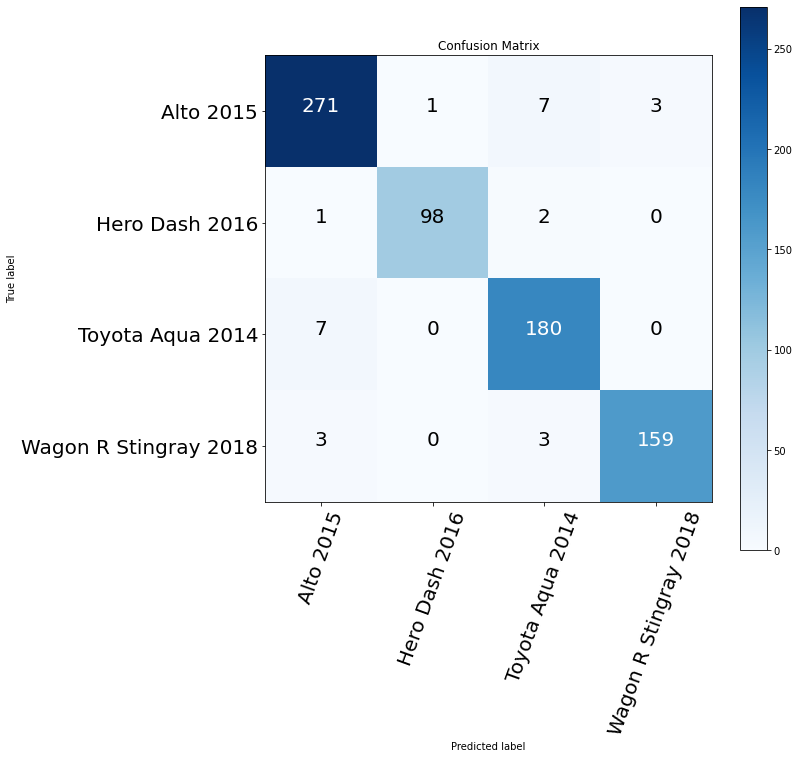

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\envs\tensorflow\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\envs\tensorflow\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\envs\tensorflow\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\envs\tensorflow\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forci

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\envs\tensorflow\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\envs\tensorflow\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\envs\tensorflow\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\envs\tensorflow\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forci

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\envs\tensorflow\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\envs\tensorflow\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\envs\tensorflow\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\envs\tensorflow\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forci

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\envs\tensorflow\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\envs\tensorflow\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\envs\tensorflow\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\envs\tensorflow\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forci

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\envs\tensorflow\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\envs\tensorflow\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\envs\tensorflow\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\envs\tensorflow\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forci

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\envs\tensorflow\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\envs\tensorflow\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\envs\tensorflow\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\envs\tensorflow\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forci

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\envs\tensorflow\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\envs\tensorflow\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\envs\tensorflow\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\envs\tensorflow\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forci

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\envs\tensorflow\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\envs\tensorflow\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\envs\tensorflow\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\envs\tensorflow\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forci

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\envs\tensorflow\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\envs\tensorflow\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\envs\tensorflow\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\envs\tensorflow\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forci

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\envs\tensorflow\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\envs\tensorflow\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\envs\tensorflow\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\envs\tensorflow\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forci

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\envs\tensorflow\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\envs\tensorflow\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\envs\tensorflow\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\envs\tensorflow\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forci

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\envs\tensorflow\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\envs\tensorflow\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\envs\tensorflow\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\envs\tensorflow\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forci

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\envs\tensorflow\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\envs\tensorflow\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\envs\tensorflow\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\envs\tensorflow\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forci

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\envs\tensorflow\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\envs\tensorflow\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\anaconda\envs\tensorflow\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\anaconda\envs\tensorflow\lib\asyncio\selector_events.py", line 120, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forci

In [153]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(10, 10),
                      text_size=20,
                      savefig=False)

In [131]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       282
           1       0.99      0.97      0.98       101
           2       0.94      0.96      0.95       187
           3       0.98      0.96      0.97       165

    accuracy                           0.96       735
   macro avg       0.97      0.96      0.97       735
weighted avg       0.96      0.96      0.96       735



In [132]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.9609929078014184,
  'recall': 0.9609929078014184,
  'f1-score': 0.9609929078014184,
  'support': 282},
 '1': {'precision': 0.98989898989899,
  'recall': 0.9702970297029703,
  'f1-score': 0.98,
  'support': 101},
 '2': {'precision': 0.9375,
  'recall': 0.9625668449197861,
  'f1-score': 0.949868073878628,
  'support': 187},
 '3': {'precision': 0.9814814814814815,
  'recall': 0.9636363636363636,
  'f1-score': 0.9724770642201834,
  'support': 165},
 'accuracy': 0.963265306122449,
 'macro avg': {'precision': 0.9674683447954725,
  'recall': 0.9643732865151347,
  'f1-score': 0.9658345114750575,
  'support': 735},
 'weighted avg': {'precision': 0.9635874046588332,
  'recall': 0.963265306122449,
  'f1-score': 0.9633524427369167,
  'support': 735}}

In [133]:
class_names

['Alto 2015', 'Hero Dash 2016', 'Toyota Aqua 2014', 'Wagon R Stingray 2018']

In [134]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'Alto 2015': 0.9609929078014184,
 'Hero Dash 2016': 0.98,
 'Toyota Aqua 2014': 0.949868073878628,
 'Wagon R Stingray 2018': 0.9724770642201834}

In [135]:
# Trun f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [136]:
f1_scores

,class_names,f1-score
1,Hero Dash 2016,0.980000
3,Wagon R Stingray 2018,0.972477
0,Alto 2015,0.960993
2,Toyota Aqua 2014,0.949868


In [137]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not
  
  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? Yes/no
  if scale:
    # rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img # don't need to rescale images for EfficientNet models in TensorFlow

## Visualizing predictions on test images

1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 25ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 27ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


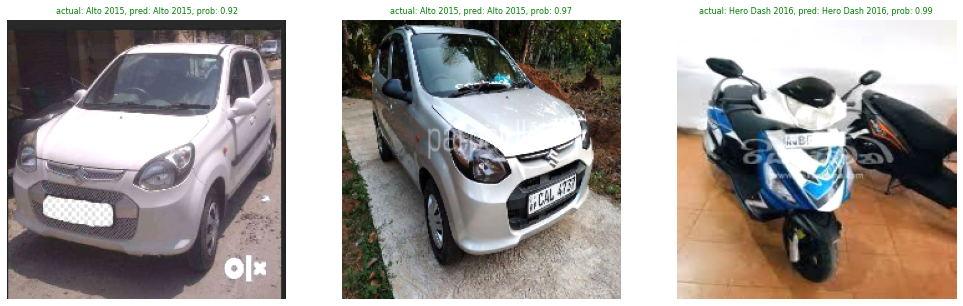

In [138]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 25))
for i in range(3):
    
    # Choose random image(s) from random class(es)
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir + "/" + class_name + "/" + filename

    # Load the image and make predictions
    img = load_and_prep_image(filepath, scale=False)
    img_expanded = tf.expand_dims(img, axis=0)
    # print(img_expanded.shape)
    pred_prob = loaded_model_1.predict(img_expanded) # get prediction probabilities array
    pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index and match it class_names list
    # print(pred_prob)
    # print(pred_class)

    # Plot the image(s)
    plt.subplot(1, 3, i+1)
    # print(img)
    plt.imshow(img/225.)
    if class_name == pred_class: # if predicted class matches truth class, make text green
        title_color = "g"
    else:
        title_color = "r"
    plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color, fontsize=8)
    plt.axis(False);

## Finding the most wrong predictions

Steps:

   * Get all of the image file paths in the test dataset using list_files() method.

   * Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names, ground truth class names.

   * Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).

   * Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top).

   * Visualize the images with the highest prediction probabilities but have the wrong prediction.


In [139]:
# 1. Get all of the image file paths in the test dataset
filepaths = []
for filepath in test_data.list_files("images/test/*/*.jpg",
                                     shuffle=False):
    filepaths.append(filepath.numpy())
filepaths[:20]

[b'images\\test\\Alto 2015\\01000.jpg',
 b'images\\test\\Alto 2015\\01004.jpg',
 b'images\\test\\Alto 2015\\01006.jpg',
 b'images\\test\\Alto 2015\\01012.jpg',
 b'images\\test\\Alto 2015\\01015.jpg',
 b'images\\test\\Alto 2015\\01020.jpg',
 b'images\\test\\Alto 2015\\01022.jpg',
 b'images\\test\\Alto 2015\\01038.jpg',
 b'images\\test\\Alto 2015\\01048.jpg',
 b'images\\test\\Alto 2015\\0105.jpg',
 b'images\\test\\Alto 2015\\01056.jpg',
 b'images\\test\\Alto 2015\\01057.jpg',
 b'images\\test\\Alto 2015\\01075.jpg',
 b'images\\test\\Alto 2015\\01080.jpg',
 b'images\\test\\Alto 2015\\01087.jpg',
 b'images\\test\\Alto 2015\\01089.jpg',
 b'images\\test\\Alto 2015\\01093.jpg',
 b'images\\test\\Alto 2015\\0110.jpg',
 b'images\\test\\Alto 2015\\01104.jpg',
 b'images\\test\\Alto 2015\\01113.jpg']

In [140]:
# 2. Create a DataFrame of different parameters for each of our test images
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'images\\test\\Alto 2015\\01000.jpg',0,0,0.993835,Alto 2015,Alto 2015
1,b'images\\test\\Alto 2015\\01004.jpg',0,0,0.946270,Alto 2015,Alto 2015
2,b'images\\test\\Alto 2015\\01006.jpg',0,0,0.978796,Alto 2015,Alto 2015
3,b'images\\test\\Alto 2015\\01012.jpg',0,0,0.982432,Alto 2015,Alto 2015
4,b'images\\test\\Alto 2015\\01015.jpg',0,0,0.940754,Alto 2015,Alto 2015
...,...,...,...,...,...,...
730,b'images\\test\\Wagon R Stingray 2018\\00818.jpg',3,3,0.997728,Wagon R Stingray 2018,Wagon R Stingray 2018
731,b'images\\test\\Wagon R Stingray 2018\\0084.jpg',3,3,0.997631,Wagon R Stingray 2018,Wagon R Stingray 2018
732,b'images\\test\\Wagon R Stingray 2018\\0086.jpg',3,3,0.773738,Wagon R Stingray 2018,Wagon R Stingray 2018
733,b'images\\test\\Wagon R Stingray 2018\\0094.jpg',3,3,0.617916,Wagon R Stingray 2018,Wagon R Stingray 2018


In [146]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'images\\test\\Alto 2015\\01000.jpg',0,0,0.993835,Alto 2015,Alto 2015,True
1,b'images\\test\\Alto 2015\\01004.jpg',0,0,0.946270,Alto 2015,Alto 2015,True
2,b'images\\test\\Alto 2015\\01006.jpg',0,0,0.978796,Alto 2015,Alto 2015,True
3,b'images\\test\\Alto 2015\\01012.jpg',0,0,0.982432,Alto 2015,Alto 2015,True
4,b'images\\test\\Alto 2015\\01015.jpg',0,0,0.940754,Alto 2015,Alto 2015,True


In [149]:
# 4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
581,b'images\\test\\Wagon R Stingray 2018\\00125.jpg',3,2,0.973755,Wagon R Stingray 2018,Toyota Aqua 2014,False
311,b'images\\test\\Hero Dash 2016\\0300.jpg',1,2,0.955640,Hero Dash 2016,Toyota Aqua 2014,False
497,b'images\\test\\Toyota Aqua 2014\\0534.jpg',2,0,0.940551,Toyota Aqua 2014,Alto 2015,False
423,b'images\\test\\Toyota Aqua 2014\\01262.jpg',2,0,0.923280,Toyota Aqua 2014,Alto 2015,False
128,b'images\\test\\Alto 2015\\035.jpg',0,2,0.887223,Alto 2015,Toyota Aqua 2014,False
16,b'images\\test\\Alto 2015\\01093.jpg',0,2,0.866461,Alto 2015,Toyota Aqua 2014,False
517,b'images\\test\\Toyota Aqua 2014\\0676.jpg',2,0,0.849947,Toyota Aqua 2014,Alto 2015,False
132,b'images\\test\\Alto 2015\\0358.jpg',0,3,0.849894,Alto 2015,Wagon R Stingray 2018,False
60,b'images\\test\\Alto 2015\\01289.jpg',0,2,0.797386,Alto 2015,Toyota Aqua 2014,False
656,b'images\\test\\Wagon R Stingray 2018\\00470.jpg',3,2,0.768720,Wagon R Stingray 2018,Toyota Aqua 2014,False


In [152]:
print(f"Number of incorrect predictions: {len(top_100_wrong)} out of {len(pred_classes)}")

Number of incorrect predictions: 27 out of 735


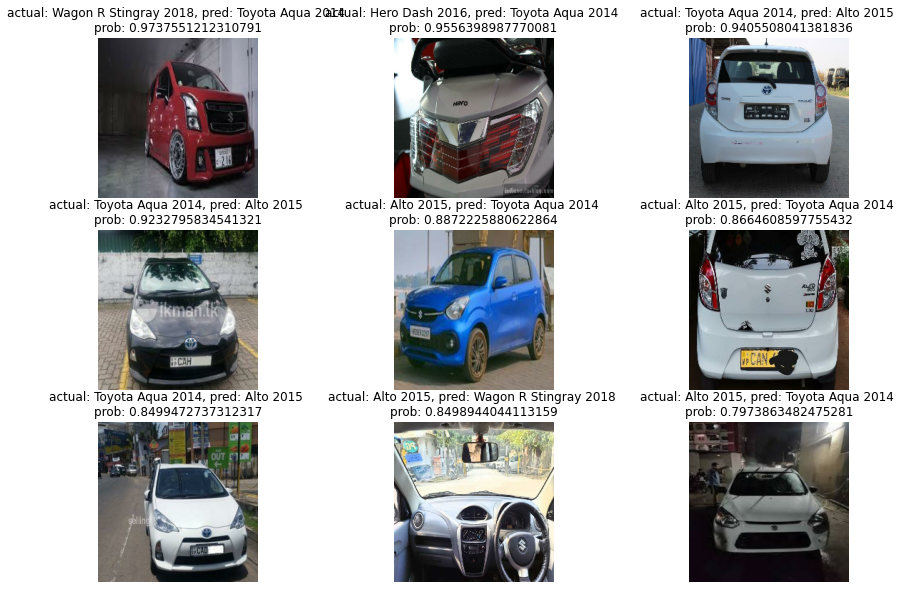

In [143]:
# 5. Visualize the test data samples which have the wrong prediction but highest pred probability
images_to_view = 9
start_index = 0
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few parameters of each row "_" is used to skip the ones you don't need
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname} \nprob: {pred_prob}")
  plt.axis(False)